In [28]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer 
from scipy import stats

from psyfun import io, atlas, spikes, util
from psyfun.config import paths, cmaps


In [29]:
df_sessions = pd.read_parquet(paths['sessions'])  # session info
df_sessions = io.add_postLSD_epochs(df_sessions)
df_units = pd.read_parquet(paths['units'])  # unit info

In [8]:
# # #to skip new recordings
df_sessions['year'] = df_sessions['start_time'].apply(lambda x: datetime.fromisoformat(x).year)
df_sessions = df_sessions.query('year < 2025')

In [30]:
print(len(df_sessions))
df_sessions = df_sessions.dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])
print(len(df_sessions))

45
37


In [31]:
# Get eids for sessions with both tasks
df_sessionquery = df_sessions.query('n_tasks >= 2')
eids = df_sessionquery['eid'].tolist()
print (len(df_sessions['eid']))
print (len(eids))


# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')
# Load spike times for good units
uuids = df_unitquery['uuid']
df_spiketimes = io.load_units(paths['spikes'], uuids)
# Join spike times with unit info
df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessionquery, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]
df_spikes['region'] = df_spikes['region'].replace({'none':np.nan})

37
37


100%|██████████| 15081/15081 [00:08<00:00, 1678.01it/s]


In [32]:
# Get spike counts for epochs of interest
epochs = ['task00_spontaneous', 'LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']
dt = 1  # get spike counts in 1s bins

for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())

Getting spike counts for: task00_spontaneous


  0%|          | 0/15081 [00:00<?, ?it/s]

100%|██████████| 15081/15081 [00:04<00:00, 3361.33it/s]


Getting spike counts for: LSD0


100%|██████████| 15081/15081 [00:04<00:00, 3363.19it/s]


Getting spike counts for: LSD600


100%|██████████| 15081/15081 [00:04<00:00, 3402.10it/s]


Getting spike counts for: LSD1200


100%|██████████| 15081/15081 [00:04<00:00, 3531.01it/s]


Getting spike counts for: task01_spontaneous


100%|██████████| 15081/15081 [00:04<00:00, 3439.74it/s]


In [33]:
# Useful metadata for analysis downstream
columns_to_keep = ['subject', 'eid', 'session_n', 'region', 'Control_recording']

pca_results = []
for idx, session_spikes in df_spikes.groupby('eid'): #add 'region' or any other columns to use for the grouping
    session_data = {col: session_spikes[col].unique()[0] for col in columns_to_keep}
    for task in ['task00_spontaneous', 'LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']: # Change 'task' be something like 'epochs'
        X = np.column_stack(session_spikes[f'{task}_counts']) # Puts all spikes into a features x samples matrix
        transformer = PowerTransformer(method='yeo-johnson', standardize=True) # Pre-processing step to satisfy gaussianity assumption in PCA
        X_rescaled = transformer.fit_transform(X) 
        pca = PCA()
        X_pcs = pca.fit_transform(X)
        session_data[f'{task}_eigenspectrum'] = pca.explained_variance_ratio_
        session_data[f'{task}_loadings'] = pca.components_
    pca_results.append(session_data)
df_pca = pd.DataFrame(pca_results)

In [34]:
df_sessions

,Control_recording,LSD_admin,alf/probe00/pykilosort/spikes.times.npy,alf/probe01/pykilosort/spikes.times.npy,alf/task_00/_ibl_passivePeriods.intervalsTable.csv,alf/task_01/_ibl_passivePeriods.intervalsTable.csv,alf/task_02/_ibl_passivePeriods.intervalsTable.csv,eid,lab,n_probes,...,videoRight_resolution_qc,videoRight_timestamps_qc,videoRight_wheel_alignment_qc,session_n,LSD0_start,LSD0_stop,LSD600_start,LSD600_stop,LSD1200_start,LSD1200_stop
0,False,1095.0,False,True,True,False,None,58ca39c5-e27f-43c4-8516-2ccc4fe88042,mainenlab,2,...,PASS,PASS,PASS,1,1095.0,1395.0,1695.0,1995.0,2295.0,2595.0
1,False,1065.0,True,True,True,True,None,7149e0fc-a52d-4e93-849c-edc22d54e7a5,mainenlab,2,...,PASS,PASS,PASS,2,1065.0,1365.0,1665.0,1965.0,2265.0,2565.0
2,False,1073.0,True,None,True,True,None,debe9833-5c26-4d9e-89ba-c63e07e1db10,mainenlab,1,...,PASS,PASS,PASS,3,1073.0,1373.0,1673.0,1973.0,2273.0,2573.0
4,False,1173.0,True,True,True,True,None,996f3585-b804-4a3d-878a-1c15d708962b,mainenlab,2,...,None,None,None,2,1173.0,1473.0,1773.0,2073.0,2373.0,2673.0
6,False,1100.0,True,True,True,True,None,2583567d-cd2a-485a-8d79-85aa619e1ce2,mainenlab,2,...,None,None,None,2,1100.0,1400.0,1700.0,2000.0,2300.0,2600.0
8,False,1063.0,True,True,True,False,None,8dfd9963-25e5-4f63-8f91-5b27a5852628,mainenlab,2,...,None,None,None,2,1063.0,1363.0,1663.0,1963.0,2263.0,2563.0
11,False,1068.0,True,True,True,True,None,a6b9f254-7682-47a4-9abd-753013c87c70,mainenlab,2,...,PASS,PASS,PASS,2,1068.0,1368.0,1668.0,1968.0,2268.0,2568.0
12,False,1065.0,True,True,True,True,None,e13d0e58-55c8-4787-a716-03549b3d0240,mainenlab,2,...,PASS,PASS,PASS,3,1065.0,1365.0,1665.0,1965.0,2265.0,2565.0
13,False,1121.0,True,True,True,True,None,a7a4a70f-57ae-4586-bb2d-37422deca541,mainenlab,2,...,PASS,PASS,PASS,1,1121.0,1421.0,1721.0,2021.0,2321.0,2621.0
14,False,1073.0,False,None,True,True,None,8868dff6-f4a6-4e84-b62c-24a0c97803c4,mainenlab,1,...,PASS,PASS,PASS,2,1073.0,1373.0,1673.0,1973.0,2273.0,2573.0


In [35]:
for task in ['task00_spontaneous', 'LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']:
    df_pca[f'{task}_pc1'] = df_pca[f'{task}_eigenspectrum'].apply(lambda x: x[0])
    df_pca[f'{task}_n80'] = df_pca[f'{task}_eigenspectrum'].apply(lambda x: np.cumsum(x).searchsorted(0.8))
    df_pca[f'{task}_powlaw'] = df_pca[f'{task}_eigenspectrum'].apply(util.power_law_slope)
    df_pca[f'{task}_ngsc'] = df_pca[f'{task}_eigenspectrum'].apply(util.ngsc)
    # Note: exponential/ bi-exponential fits often poorly characterize these eigenspectra
    # df_pca[f'{task}_tau'] = df_pca[f'{task}_eigenspectrum'].apply(_get_exp_tau)
    # df_pca[f'{task}_lifetime'] = df_pca[f'{task}_eigenspectrum'].apply(_get_biexp_mean_lifetime)

In [69]:
df_pca['start_time'] = df_sessions ['start_time']
df_pca.columns

Index(['subject', 'eid', 'session_n', 'region', 'Control_recording',
       'task00_spontaneous_eigenspectrum', 'task00_spontaneous_loadings',
       'LSD0_eigenspectrum', 'LSD0_loadings', 'LSD600_eigenspectrum',
       'LSD600_loadings', 'LSD1200_eigenspectrum', 'LSD1200_loadings',
       'task01_spontaneous_eigenspectrum', 'task01_spontaneous_loadings',
       'task00_spontaneous_pc1', 'task00_spontaneous_n80',
       'task00_spontaneous_powlaw', 'task00_spontaneous_ngsc', 'LSD0_pc1',
       'LSD0_n80', 'LSD0_powlaw', 'LSD0_ngsc', 'LSD600_pc1', 'LSD600_n80',
       'LSD600_powlaw', 'LSD600_ngsc', 'LSD1200_pc1', 'LSD1200_n80',
       'LSD1200_powlaw', 'LSD1200_ngsc', 'task01_spontaneous_pc1',
       'task01_spontaneous_n80', 'task01_spontaneous_powlaw',
       'task01_spontaneous_ngsc', 'pc1_angle', 'start_time'],
      dtype='object')

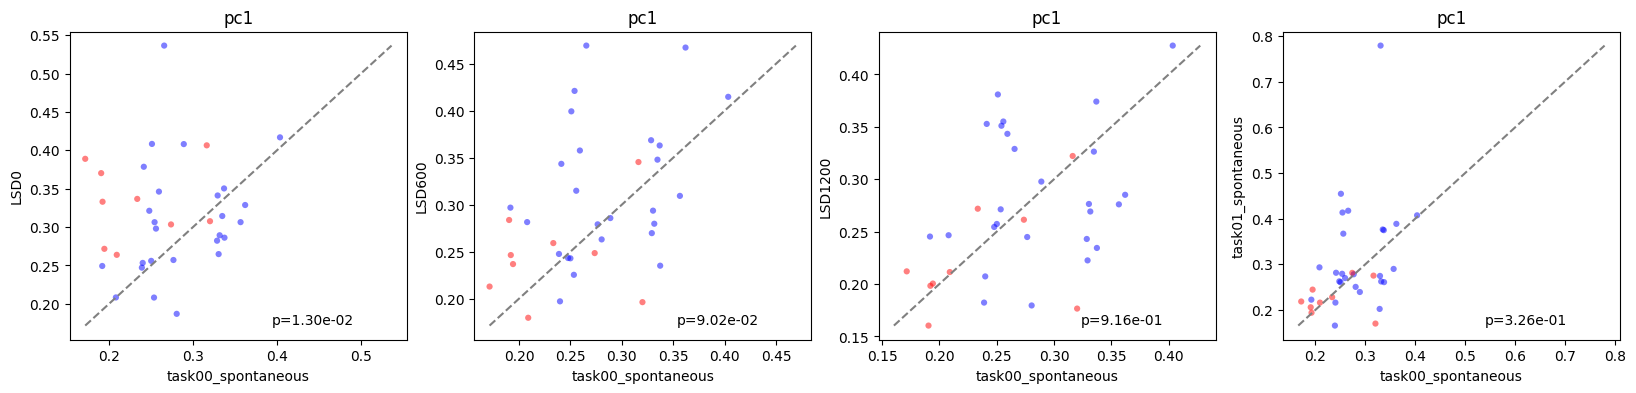

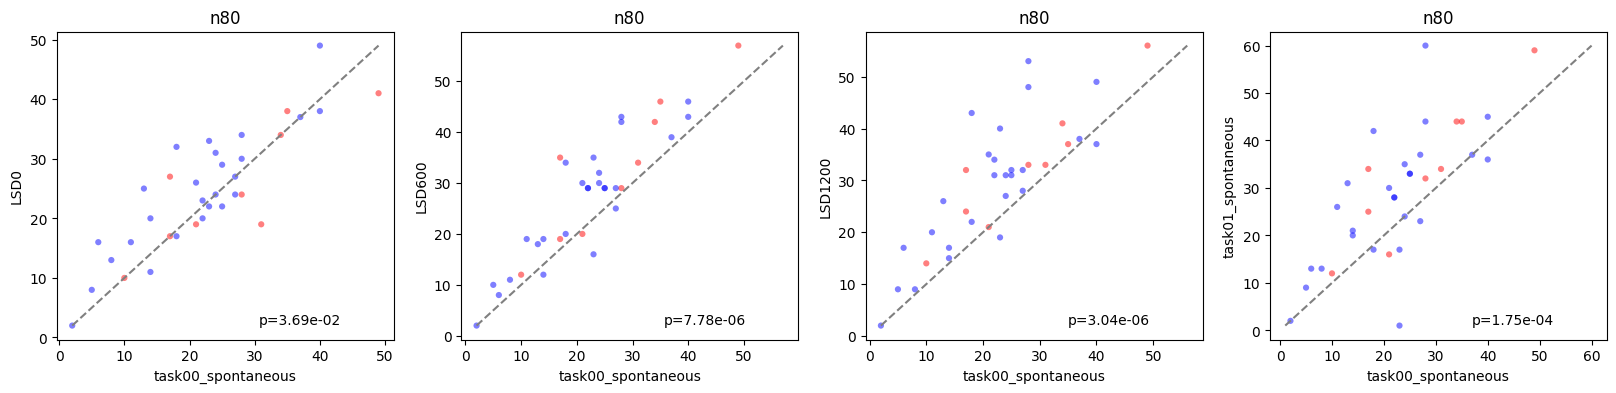

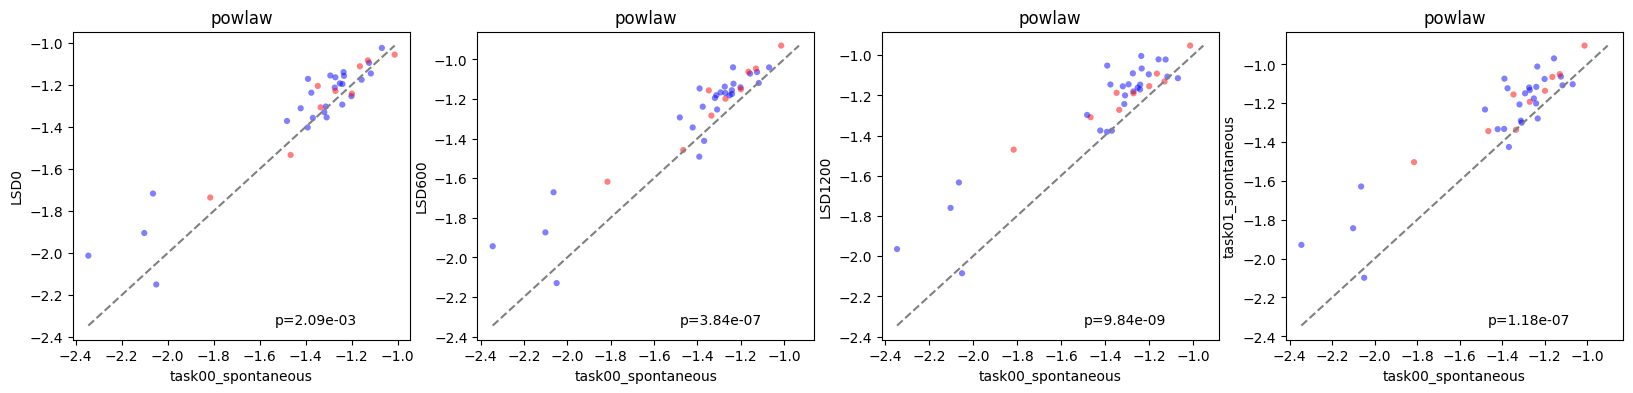

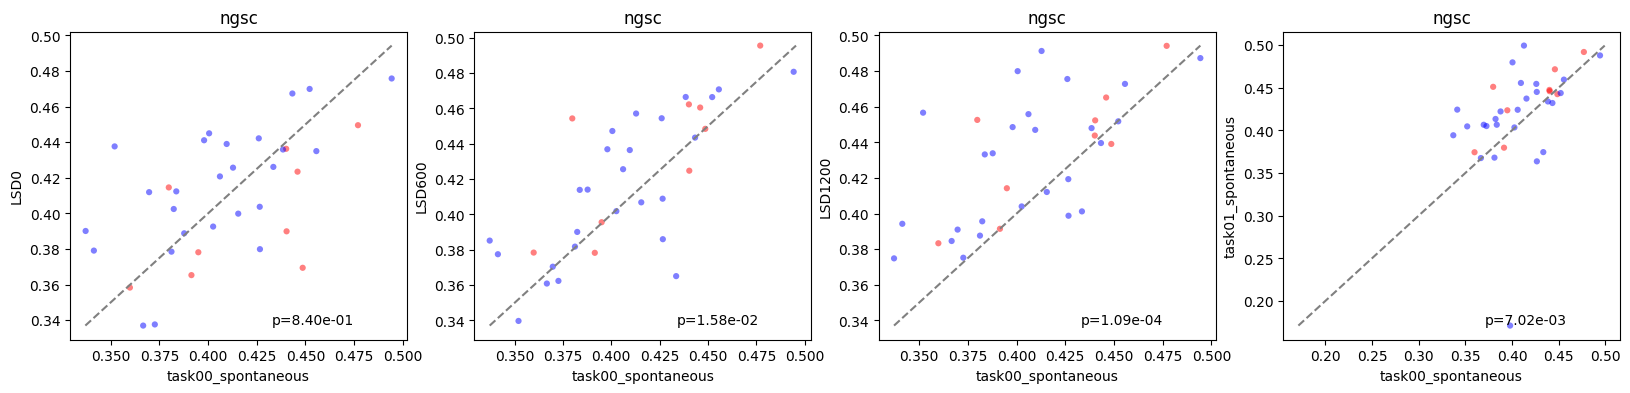

In [70]:
for val in ['pc1', 'n80', 'powlaw', 'ngsc']:
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))  # 1 row, 4 columns, each plot 3x3 
    for idx, task in enumerate(['LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']):
        ax = axs[idx]
        ax.set_title(val)
        
        xx = df_pca[f'task00_spontaneous_{val}']
        yy = df_pca[f'{task}_{val}']

        colors = df_pca['Control_recording'].map({True: 'r', False: 'b'})

        ax.scatter(xx, yy, s=20, c=colors, edgecolor='none', alpha=0.5)
        data_range = (min(xx.min(), yy.min()), max(xx.max(), yy.max()))
        ax.plot(data_range, data_range, ls='--', color='gray')

        ax.set_xlabel('task00_spontaneous')
        ax.set_ylabel(f'{task}')

        w, p = stats.wilcoxon(xx, yy)
        ax.text(0.6, 0.05, f'p={p:.2e}', transform=ax.transAxes)

    # Display the combined figure
    plt.show()

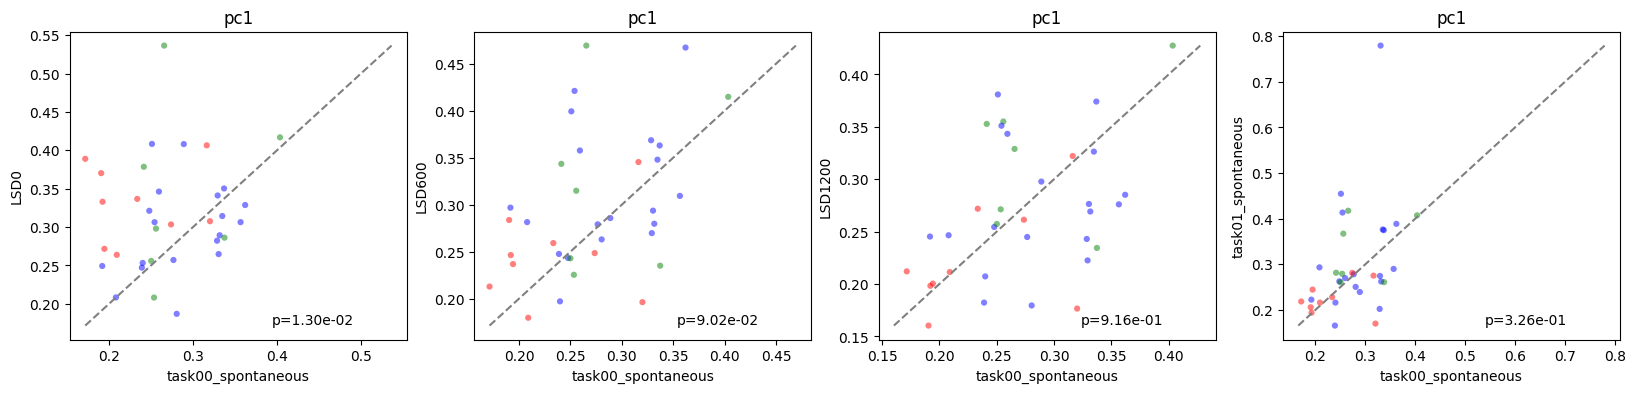

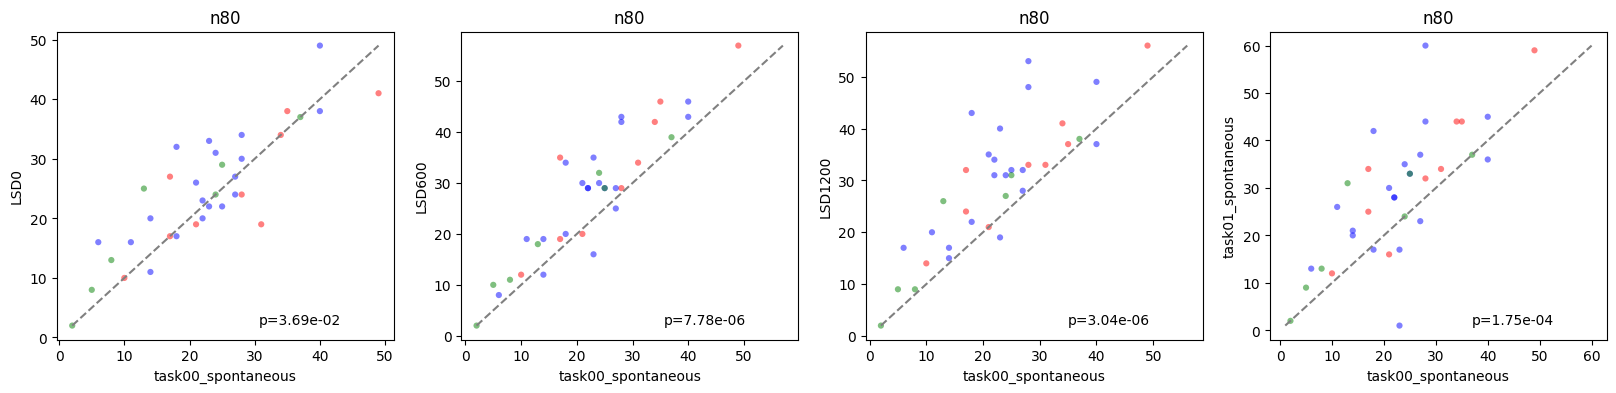

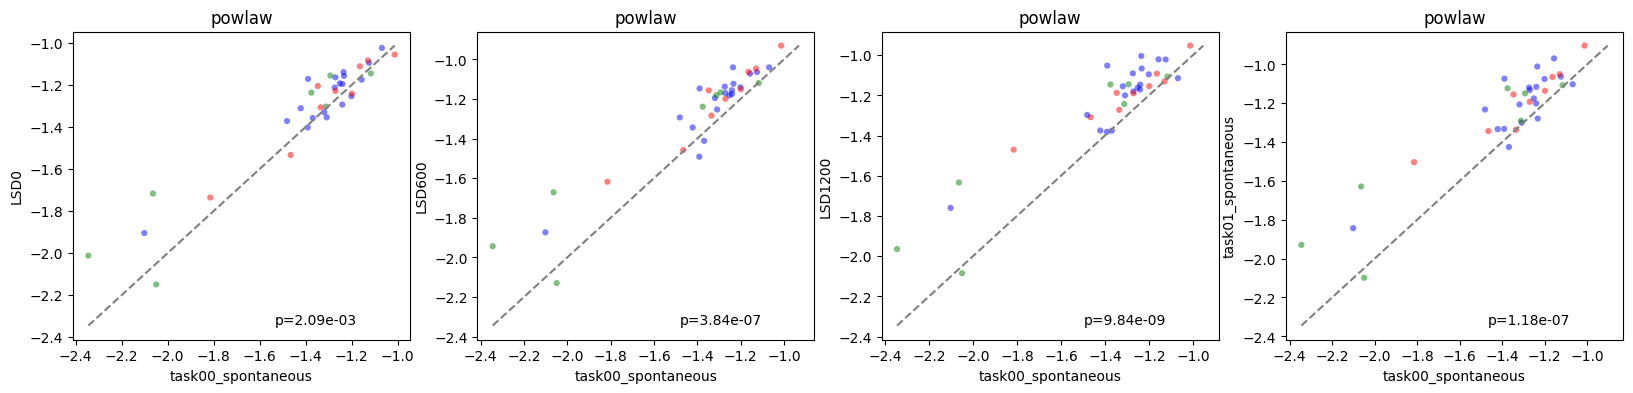

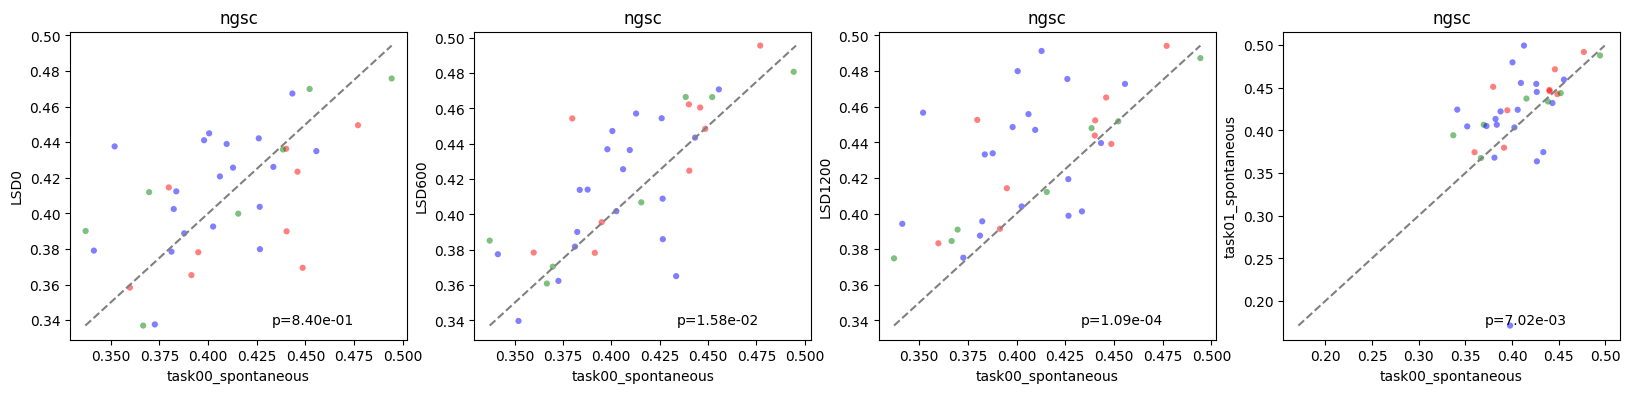

In [71]:

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Create a function to map conditions to colors
def create_color(row):
    if row['Control_recording']:
        return 'r'
    if pd.to_datetime(row['start_time']).year < 2025:
        return 'b'
    return 'g'

df_pca['color'] = df_pca.apply(create_color, axis=1)

for val in ['pc1', 'n80', 'powlaw', 'ngsc']:
    fig, axs = plt.subplots(1, 4, figsize=(20, 4)) 
    for idx, task in enumerate(['LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']):
        ax = axs[idx]
        ax.set_title(val)
        
        xx = df_pca[f'task00_spontaneous_{val}']
        yy = df_pca[f'{task}_{val}']
        colors = df_pca['color']

        ax.scatter(xx, yy, s=20, c=colors, edgecolor='none', alpha=0.5)
        data_range = (min(xx.min(), yy.min()), max(xx.max(), yy.max()))
        ax.plot(data_range, data_range, ls='--', color='gray')

        ax.set_xlabel('task00_spontaneous')
        ax.set_ylabel(f'{task}')

        w, p = stats.wilcoxon(xx, yy)
        ax.text(0.6, 0.05, f'p={p:.2e}', transform=ax.transAxes)

    plt.show()

In [38]:
def angle(v1, v2):
    """
    Compute the angle between two vectors v1 and v2.
    
    Parameters
    ----------
    v1, v2 : array_like
        The two vectors (e.g. PC1 directions) between which to compute the angle.
    
    Returns
    -------
    angle_rad : float
        Angle in radians.
    angle_deg : float
        Angle in degrees.
    """
    # Compute dot product and norms.
    dot = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Avoid numerical issues: clip the cosine value to the valid range [-1, 1]
    cos_theta = np.clip(dot / (norm_v1 * norm_v2), -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    # angle_deg = np.degrees(angle_rad)
    return angle_rad

In [72]:
df_pca

,subject,eid,session_n,region,Control_recording,task00_spontaneous_eigenspectrum,task00_spontaneous_loadings,LSD0_eigenspectrum,LSD0_loadings,LSD600_eigenspectrum,...,LSD1200_n80,LSD1200_powlaw,LSD1200_ngsc,task01_spontaneous_pc1,task01_spontaneous_n80,task01_spontaneous_powlaw,task01_spontaneous_ngsc,pc1_angle,start_time,color
0,ZFM-06187,0bd26d4d-c1c1-4f59-af13-59d19b597ab6,2,TTd,False,"[0.33685183117513395, 0.08465968855586273, 0.0...","[[-0.022033183804981427, -0.03256016017087138,...","[0.3501941799352201, 0.07999119138738238, 0.06...","[[-0.001841602326258296, -0.04176192824511449,...","[0.36303828112820974, 0.08625283383152915, 0.0...",...,32,-1.095762,0.404009,0.374613,33,-1.075799,0.403401,0.732231,2023-03-21T11:45:48.885186,b
1,ZFM-06048,1cbb24d0-2188-45dc-a116-e23a089c62b4,1,CP,False,"[0.35652551906397517, 0.09177703668891671, 0.0...","[[0.000553587586710369, -0.0001027549861937204...","[0.30625631903454703, 0.08157172280519832, 0.0...","[[0.0013636236199431329, 0.0011898857598441337...","[0.3094223463626459, 0.12131294728515772, 0.04...",...,35,-1.090941,0.433203,0.289653,30,-1.119690,0.406568,0.760621,2023-03-28T12:16:34.328991,b
2,ZFM-05496,2583567d-cd2a-485a-8d79-85aa619e1ce2,2,TTd,False,"[0.1917088093114469, 0.18243158840608248, 0.13...","[[-0.09054835333342298, -0.1450228987949741, -...","[0.2491069476593514, 0.14541774465384774, 0.10...","[[0.03648477327267574, 0.02493276735705474, 0....","[0.2969212267831396, 0.14796584568584373, 0.06...",...,17,-1.375120,0.395653,0.222308,21,-1.334037,0.413324,1.394410,2023-04-04T11:26:16.745718,b
3,ZFM-08458,3e9d9490-7fb2-4aa3-b8cd-83f216ad8cde,1,None,True,"[0.1942325301593623, 0.12473810107748523, 0.07...","[[-0.0018499327195063975, -0.00033445473498228...","[0.27148416204759607, 0.10167182336476895, 0.0...","[[0.0031478511700680223, -0.000166365910129528...","[0.23686219022012905, 0.05242318321211819, 0.0...",...,56,-0.952904,0.494148,0.244345,59,-0.903862,0.491830,1.503032,NaN,r
4,ZFM-06296,4b398979-c54c-498f-a3d4-b201c2285be5,1,COApm,False,"[0.23991978563459976, 0.1691894288054545, 0.11...","[[0.0003295536106420472, -0.000677683170992190...","[0.2531100044237115, 0.14007032068072695, 0.08...","[[-0.00038014004281494186, 0.00056564796079217...","[0.1972085762994235, 0.16294583784007652, 0.06...",...,53,-1.021432,0.491266,0.215909,60,-0.969857,0.499321,1.667818,2022-12-15T17:50:45.692961,b
5,ZFM-08584,4e3f021c-e553-4c67-988a-0ca52535748e,2,None,False,"[0.2412252993467785, 0.1616339351114862, 0.059...","[[0.06311690592973396, 0.01372034448479631, 0....","[0.37844500083452076, 0.0610606187241943, 0.04...","[[0.030772102723890637, 0.04413969204131096, 0...","[0.3435077132320195, 0.08199613519938635, 0.06...",...,31,-1.145506,0.412117,0.281265,33,-1.149639,0.437212,0.640352,NaN,g
6,ZFM-06301,50322fbb-5b93-46d7-9ca0-391fa30c966a,1,TH,False,"[0.20796929854118146, 0.17417689431591205, 0.0...","[[0.10836830288862158, 0.021903335262193346, 0...","[0.20810928651936056, 0.11930745663390903, 0.0...","[[0.15765987411187882, -0.0017729059846088857,...","[0.2815219818854871, 0.1304395951675111, 0.040...",...,37,-1.115015,0.439593,0.293094,36,-1.102881,0.432018,2.142845,2022-12-15T12:59:46.966168,b
7,ZFM-06047,53d8cb2f-3338-4bcd-81c4-6207b660eba3,1,CP,False,"[0.2557253391685449, 0.17670199825969915, 0.12...","[[9.429802702620727e-05, 9.868824626646511e-05...","[0.29783782440963735, 0.09244530963202664, 0.0...","[[-0.0027050943622370094, 0.003046083210341832...","[0.31489045743934585, 0.20515085975310116, 0.0...",...,26,-1.146238,0.391001,0.366904,31,-1.123449,0.406528,1.112979,NaN,g
8,ZFM-08458,55f3644c-3f86-423e-9beb-6604b5aa4e2c,2,None,True,"[0.23341529633814026, 0.18121703221214516, 0.0...","[[0.0047560773168637245, 0.01722049028170658, ...","[0.3365536621824036, 0.10053918658879588, 0.05...","[[0.0002416561513445391, 0.0012656472665278917...","[0.2592070295346008, 0.13737792525396622, 0.08...",...,24,-1.308996,0.414222,0.227784,25,-1.343921,0.423482,1.011806,2023-01-31T15:07:25.7585

In [82]:
df_pca['pc1_angle'] = df_pca.apply(lambda x: angle(x['task00_spontaneous_loadings'][0], x['task01_spontaneous_loadings'][0]), axis='columns') 
# df_pca['pc1_angle'] = df_pca.apply(lambda x: angle(x['task00_spontaneous_eigenspectrum'][0], x['task01_spontaneous_eigenspectrum'][0]), axis='columns') 

[]

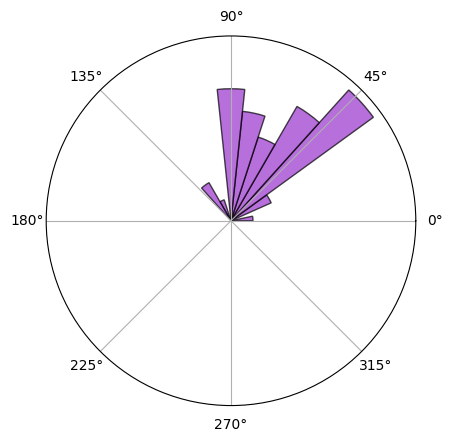

In [83]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Define number of bins for the histogram
num_bins = 30
bins = np.linspace(0, 2*np.pi, num_bins + 1)
# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2.0
width = 2 * np.pi / num_bins

# Compute histogram counts (frequency for each bin)
counts, _ = np.histogram(df_pca['pc1_angle'], bins=bins)

# Plot the histogram as bars on the polar plot
ax.bar(bin_centers, counts, width=width, align='center', alpha=0.7, fc=cmaps['LSD'](1.), ec='black')
ax.set_yticks([])
# ax.set_title('PC1 rotation')

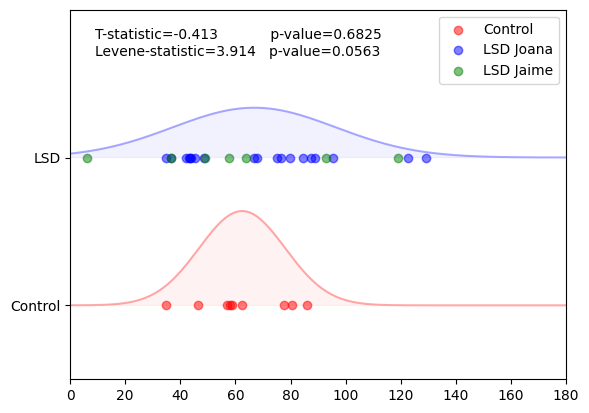

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import ttest_ind, levene

# Separate the data
df_true = df_pca[df_pca['Control_recording'] == True]['pc1_angle'].apply(np.degrees)
df_false = df_pca[df_pca['Control_recording'] == False]['pc1_angle'].apply(np.degrees)
df_false_colors = df_pca[df_pca['Control_recording'] == False]['color'].unique() # Get unique colors

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the control data
ax.scatter(df_true, [0]*len(df_true), color='red', label='Control', alpha=0.5)

# Plot the LSD data, creating separate scatter plots per unique color
for color in df_false_colors:
  df_color = df_false[df_pca['color'] == color]
  if color == 'b':
      ax.scatter(df_color, [1]*len(df_color), color=color, label=f'LSD Joana', alpha=0.5)
  if color == 'g':
      ax.scatter(df_color, [1]*len(df_color), color=color, label=f'LSD Jaime', alpha=0.5)

# Perform statistical tests
t_stat, p_val_t = ttest_ind(df_true, df_false, equal_var=True)
l_stat, p_val_l = levene(df_true, df_false)

# Display test results on plots
ax.text(0.05, 0.95,
        f"T-statistic={t_stat:.3f}            p-value={p_val_t:.4f}\nLevene-statistic={l_stat:.3f}   p-value={p_val_l:.4f}",
        ha='left', va='top', transform=ax.transAxes)

# Fit a normal distribution to the data and plot
x = np.linspace(0, 360, 1000)

mu_true, std_true = norm.fit(df_true)
pdf_true = norm.pdf(x, mu_true, std_true)
ax.plot(x, pdf_true * 25, color='red', alpha = 0.3) # Adjust heights by multiplying with a constant
ax.fill_between(x, pdf_true * 25, alpha=0.05, color='red')

mu_false, std_false = norm.fit(df_false)
pdf_false = norm.pdf(x, mu_false, std_false)
ax.plot(x, pdf_false * 25 + 1, color='blue', alpha = 0.3)  # Adjust heights by multiplying with a constant and adding 1
ax.fill_between(x, pdf_false * 25 + 1, 1, alpha=0.05, color='blue')

# Configure y-axis
ax.set_yticks([0, 1])
ax.set_yticklabels(['Control', 'LSD'])
ax.set_ylim([-0.5, 2])

# Configure x-axis
ax.set_xlim([0, 180])

# Add a legend
ax.legend()

plt.show()

In [67]:
from scipy.stats import ttest_ind, levene

# Perform t-test
t_stat, p_val_t = ttest_ind(df_true, df_false, equal_var=True)
print(f"T-test result: T-statistic={t_stat}, p-value={p_val_t}")

# Levene variance test
l_stat, p_val_l = levene(df_true, df_false)
print(f"Levene's test result: Levene-statistic={l_stat}, p-value={p_val_l}")

T-test result: T-statistic=-0.41265167971796113, p-value=0.6825306136423954
Levene's test result: Levene-statistic=3.9135176313845235, p-value=0.05629737738046958


(array([1., 0., 3., 5., 3., 3., 4., 1., 0., 3.]),
 array([  6.10622088,  18.40197361,  30.69772634,  42.99347906,
         55.28923179,  67.58498451,  79.88073724,  92.17648997,
        104.47224269, 116.76799542, 129.06374814]),
 <BarContainer object of 10 artists>)

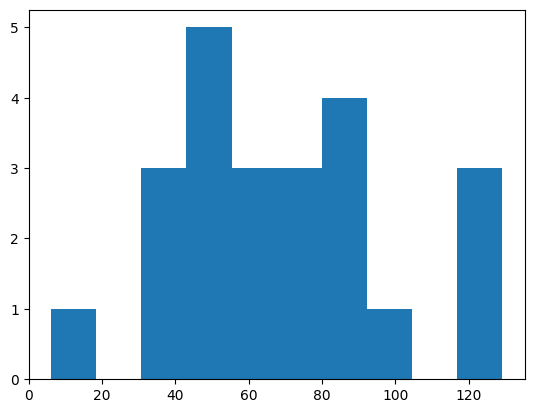

In [27]:
fig, ax = plt.subplots()
ax.hist(np.degrees(df_pca['pc1_angle']))